# Test viscous liquid transfer

The objective of this Jupyter notebook is to guide the user through the process of obtaining the liquid handling parameters that can accutately transfer volumes of viscous liquids using a rLine1000 automatic pipette. The process is based on a gravimetric method where the volume transfered with the autoamted pipette is compared with the expected mass for the transfer. The parameters are tuned to minimize the relative error calculated from the measured mass in comparison to the expected mass for each transfer. 


## Initialization of automated plarform

In [1]:
#Import relevant python packages
import pandas as pd
import time
from matplotlib import pyplot as plt
from pathlib import Path
import sys
REPOS = 'GitHub'
ROOT = str(Path().absolute()).split(REPOS)[0]
sys.path.append(f'{ROOT}{REPOS}')

from polylectric.configs.SynthesisB1 import SETUP, LAYOUT_FILE

from controllably import load_deck      # optional
load_deck(SETUP.setup, LAYOUT_FILE)     # optional

platform = SETUP
platform.mover.verbose = False


Import: OK <controllably.misc.decorators>
Import: OK <controllably.misc.helper>
Import: OK <controllably.misc.factory>
Import: OK <controllably.misc.layout>
Import: OK <controllably.misc.logger>
Import: OK <controllably.misc.misc_utils>


Import: OK <controllably.Compound.compound_utils>
Import: OK <controllably.Compound.LiquidMover.liquidmover_utils>


Import: OK <controllably.Move.move_utils>
Import: OK <controllably.Move.Jointed.jointed_utils>
Import: OK <controllably.Move.Jointed.Dobot.dobot_utils>
Import: OK <controllably.Move.Jointed.Dobot.m1pro_utils>
Import: OK <controllably.Move.Jointed.Dobot.mg400_utils>
ClearError()
receive: ClearError()
EnableRobot()
receive: EnableRobot()
User(0)
receive: User(0)
Tool(0)
receive: Tool(0)
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
Infeasible coordinates! (0.0, 0.0, 200.0)
Infeasible coordinates! (300.0, 1.1368683772161603e-13, 0.0)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 3.000s (1.000x

In [2]:
#Initialization of variables for platfomr objects
pipette= platform.setup
deck = platform.setup.deck
balance = platform.balance
balance_deck = deck.slots['1']
source = deck.slots['2']
tip_rack = deck.slots['3']
bin = deck.slots['4']
pipette.mover.setSpeed(50)
print(balance_deck)
print(source)
print(tip_rack)
print(bin)




SpeedFactor(50)
receive: SpeedFactor(50)
Mass_balance_plastic_jar 1 Well Plate 15000 uL at Slot 1
Polyelectric 6 Well Plate 15000 ÂµL at Slot 2
Eppendorf Motion 96 Tip Rack 1000 ÂµL at Slot 3
Polyetric_bin at Slot 4


In [4]:
#Check if balance is connected
balance.zero()
balance.toggleRecord(True)
time.sleep(5)
print(balance.buffer_df.iloc[-1])
balance.toggleRecord(False)

Listening...Zeroing... (5s)

Stop listening...
Zeroing complete.
Listening...
Time        2023-05-03 14:50:55.932785
Value                           217375
Factor                        6.862879
Baseline                 217397.926174
Mass                         -3.340606
Name: 24, dtype: object
Stop listening...


In [179]:
#Stablish initial height of liquid on the source vial
liquid_level = 12.5

In [210]:
pipette.liquid.eject()

'ok'

In [6]:
#Initialize OT2 for pipetting
pipette.attachTip()
pipette.mover.home()

Tip capacitance: 269
A1
Tip capacitance: 267
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.200x)
[3.00000000e+02 1.13686838e-13 2.00000000e+02], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(198.894071,-3.942538,200.000000,10.000000,0.000000,0.000000)
Move time: 2.022s (0.500x)
[198.89407123  -3.94253829 200.        ], [10  0  0]
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(198.894071,-3.942538,65.400000,10.000000,0.000000,0.000000)
Move time: 6.730s (0.200x)
[198.89407123  -3.94253829  65.4       ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(1)
receive: SpeedFactor(1)
MovJ(198.894071,-3.942538,45.400000,10.000000,0.000000,0.000000)
Move time: 20.000s (0.010x)
[198.89407123  -3.94253829  45.4       ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(198.894071,-3.942538,162.300000,10.000000,0.000000,0.000000)
Move time: 5.845

True

## Viscous liquid protocol: Coarse approximation of pipetting parameters

The first step is to obtain approximate values of aspiration and dispense rates that can be used to initia;ize the ;iqiid transfer such as aspiration and dispense rates. 

In [7]:
#This commands will aspirate 1000ul liquid at standard flow_rate.aspirate of pippette. A timer well be started just before aspiration starts
pipette.mover.setHandedness(False)
pipette.mover.safeMoveTo(source.wells['A1'].from_bottom((0,0,liquid_level-3)))
start = time.time()
pipette.liquid.aspirate(1000)

SetArmOrientation(0,1,1,1)
receive: SetArmOrientation(0,1,1,1)
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (1.000x)
[3.00000000e+02 1.13686838e-13 2.00000000e+02], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 2.934s (0.500x)
[ 206.84309407 -146.68214574  200.        ], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,59.510000,10.000000,0.000000,0.000000)
Move time: 1.405s (1.000x)
[ 206.84309407 -146.68214574   59.51      ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 1000.0 uL...
Aspiration time: 2.439334199996665s


'ok'

In [8]:
#Run this cell when no further flow of liquid into the pipette tip is observed. Calculates an approximate flow rate for 
#aspiration
finish = time.time()
t_aspirate = finish-start
flow_rate_aspirate = 1000/t_aspirate
flow_rate_aspirate

80.88705181065001

In [9]:
#This commands will dispense 900 ul of liquid at a flow rate equal to the approximation for aspiration obtained above.
#User should observe the behaviour of the dispense to make an educated guess of initial dispense rate to be implemented.
pipette.mover.safeMoveTo(source.wells['A1'].top)
pipette.liquid.dispense(1000, speed = round(flow_rate_aspirate,1))


SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 1.405s (1.000x)
[ 206.84309407 -146.68214574  200.        ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[ 206.84309407 -146.68214574  200.        ], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,73.510000,10.000000,0.000000,0.000000)
Move time: 1.265s (1.000x)
[ 206.84309407 -146.68214574   73.51      ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Dispensing 1000.0 uL...
Target: 1000.0 uL at 80.9 uL/s...
Best parameters: SpeedParameters(preset=1120, intervals=11, step_size=36, delay=1.0425529353217857)
SpeedParameters(preset=1120, intervals=11, step_size=36, delay=1.0425529353217857)
Speed 6: 1120 uL/s
Dispense time: 12.366699600010179s


'ok'

In [197]:
#This command will clear out remaining liquid in the tip if the dispense was incomplete.

pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()

pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()

pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()


SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(206.843094,-146.682146,63.510000,10.000000,0.000000,0.000000)
Move time: 0.500s (0.200x)
[ 206.84309407 -146.68214574   63.51      ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(207.104567,-129.734163,63.510000,10.000000,0.000000,0.000000)
Move time: 0.847s (0.200x)
[ 207.10456737 -129.73416262   63.51      ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(206.581621,-163.630129,63.510000,10.000000,0.000000,0.000000)
Move time: 1.695s (0.200x)
[ 206.58162078 -163.63012886   63.51      ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(206.843094,-146.682146,63.510000,10.000000,0.000000,0.000000)
Move time: 0.847s (0.200x)
[ 206.84309407 -146.68214574   63.51      ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(189.895111,-146.420672,63.

'ok'

## Viscous liquid protocol: Gravimetric analysis for obtaining pipetting parameters to transfer a viscous liquid 
The following cells contain the code required to implemenet the gravimetric analysis of volume transfer of a specific viscousl iquid. User only needs to input the targetr volume, density of the liquid and mass of vials before and after a dispense.

Define liquid to be handeled and input initial aspiration and dispense rates

In [11]:
#Load dataframe
liquid_name = "Viscosity_std_505"
density = 0.8683
pipette_name = 'rLine1000'


First initialize or load a previous dataframe to record transfer parameters. Use only one of the next to cells. 

In [12]:
#New dataframe
df = pd.DataFrame(columns = ['liquid', 'pipette', 'volume', 'aspiration_rate', 'dispense_rate','blow_out', 'delay_aspirate', 'delay_dispense', 'delay_blow_out', 'density', 'time', 'm', '%error', 'Transfer_Observation', 'Comment'])
df = df.astype({'liquid':str,'pipette':str,'blow_out':bool,'Transfer_Observation':str,'Comment':str})

In [ ]:
#load dataframe if experiment was done halfway previously
df = pd.read_csv(liquid_name+'.csv')

In [13]:
liquids_dict = {
  liquid_name :{
        "rLine1000": {
            "aspiration_rate": flow_rate_aspirate, 
            "dispense_rate": flow_rate_aspirate, 
            "blow_out" : False, 
            "delay_aspirate" : 5, 
            "delay_dispense" : 5, 
            "delay_blow_out" : 0, 
            },
    }

}


Transfer viscous liquds, input pippette name (pipette), desired volume (volume) to be dispensed in ul, liquid dictonary key string (liquid), density (density) and initial vial mass (mi). The code will register the liquid handling parameters used into the dataframe  

In [206]:
#Update target volume for transfer
volume=500

#Check if new tip is required
pipette.mover.setSpeed(50)

if pipette.liquid.isTipOn()== False:
    pipette.attachTip()

#Transfer start
start = time.time()

#Aspirate step
pipette.mover.safeMoveTo(source.wells['A1'].from_bottom((0,0,liquid_level-3)))
pipette.liquid.aspirate(volume, speed=liquids_dict[liquid_name][pipette_name]['aspiration_rate'])
time.sleep(liquids_dict[liquid_name][pipette_name]['delay_aspirate'])

pipette.touchTip(source.wells['A1'])

#Dispense step
pipette.mover.safeMoveTo(balance_deck.wells['A1'].from_top((0,0,-5)))

balance.tare()
balance.clearCache()
balance.toggleRecord(True)
time.sleep(5)


pipette.liquid.dispense(volume, speed=liquids_dict[liquid_name][pipette_name]['dispense_rate'])

time.sleep(liquids_dict[liquid_name][pipette_name]['delay_dispense'])

#Blowout step
if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
    pipette.liquid.blowout(home=False)
    time.sleep.delay(seconds = liquids_dict[liquid_name][pipette_name]['delay_blow_out'])

#Transfer termination
finish = time.time()
time_m = finish - start

pipette.mover.safeMoveTo(source.wells['A1'].top)
time.sleep(5)
balance.toggleRecord(False)
if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
    pipette.liquid.home()



Tip capacitance: 262
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (1.000x)
[3.00000000e+02 1.13686838e-13 2.00000000e+02], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 2.934s (0.500x)
[ 206.84309407 -146.68214574  200.        ], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,56.010000,10.000000,0.000000,0.000000)
Move time: 1.440s (1.000x)
[ 206.84309407 -146.68214574   56.01      ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 500.0 uL...
Target: 500.0 uL at 70 uL/s...
Best parameters: SpeedParameters(preset=265, intervals=5, step_size=40, delay=1.0512129380053907)
SpeedParameters(preset=265, intervals=5, step_size=40, delay=1.0512129380053907)
Speed 2: 265 uL/s
Aspiration time: 7.1451373000163585s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(206.843094,-146.682146,63

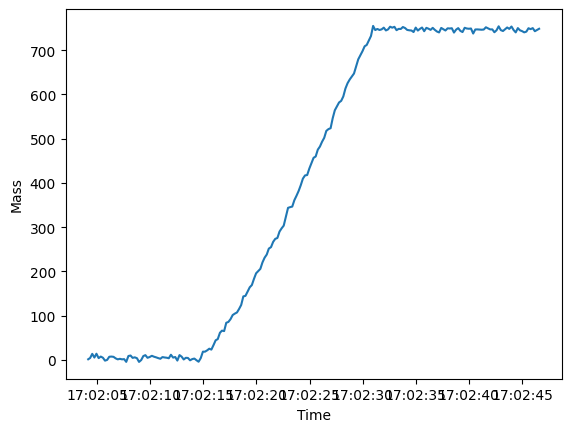

In [199]:
fig,axs = plt.subplots()

axs.plot(balance.buffer_df['Time'],balance.buffer_df['Mass'])

axs.set_xlabel('Time')
axs.set_ylabel('Mass')

plt.show()

In [200]:
#Record trasnfer values 

m = (balance.buffer_df.iloc[-10:,-1].mean()-balance.buffer_df.iloc[:10,-1].mean())/1000

df = pd.concat([df,pd.DataFrame(liquids_dict[liquid_name][pipette_name],index=[0])],ignore_index=True)
error = (m-density*volume/1000)/(density/1000*volume)*100
df.iloc[-1,-5] = time_m
df.iloc[-1,2] = volume
df.iloc[-1, 0] = liquid_name
df.iloc[-1, 1] = pipette_name
df.iloc[-1,-6] = density
df.iloc[-1, -4] = m
df.iloc[-1,-3]= error


In [201]:
#Update liquid level
liquid_level = liquid_level - 1*volume/1000

In [202]:
liquid_level

9.5

In [203]:
#Observe error made
df 

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,Transfer_Observation,Comment
0,Viscosity_std_505,rLine1000,1000,80.887052,80.887052,False,5,5,0,0.8683,77.91945,0.715123,-17.641072,Incomplete dispense,No comment
1,Viscosity_std_505,rLine1000,500,80.887052,80.887052,False,5,5,0,0.8683,65.322878,0.396219,-8.73695,Incomplete dispense,Unsure abaout mass reading repeated
2,Viscosity_std_505,rLine1000,100,80.887052,80.887052,False,5,5,0,0.8683,56.181768,0.064871,-25.289957,Incomplete dispense,No comment
3,Viscosity_std_505,rLine1000,500,80.887052,80.887052,False,5,5,0,0.8683,65.341112,0.367149,-15.432662,Incomplete dispense,No comment
4,Viscosity_std_505,rLine1000,1000,80.887052,75.000000,False,5,5,0,0.8683,78.712592,0.744498,-14.257976,Incomplete dispense,Mass read -70000 once
5,Viscosity_std_505,rLine1000,500,80.887052,75.000000,False,5,5,0,0.8683,65.921569,0.375265,-13.563233,Incomplete dispense,No comment
6,Viscosity_std_505,rLine1000,100,80.887052,75.000000,False,5,5,0,0.8683,55.671052,0.070277,-19.06412,Incomplete dispense,No comment
7,Viscosity_std_505,rLine1000,1000,80.887052,65.000000,False,5,5,0,0.8683,81.030215,0.735755,-15.264849,Incomplete dispense,No comment
8,Viscosity_std_505,rLine1000,500,80.887052,65.000000,False,5,5,0,0.8683,67.079345,0.399978,-7.871039,Incomplete dispense,No comment
9,Viscosity_std_505,rLine1000,100,80.887052,65.000000,False,5,5,0,0.8683,56.084945,0.071151,-18.057246,Incomplete dispense,No blowout before aspirate


In [204]:
#Assign category of observation of transfer such as Incomplete Dispense, Incomplete Aspiration, 
#Incomplete Aspiration and Dispense, Complete Transfer. 
#Comment if any unexpected exprimental mistakes or changes were performed that have to be taken into account.
df.iloc[-1,-2]= 'Incomplete dispense'
df.iloc[-1,-1]= 'With blowout but bubbles in pipette'

Update dictionary with new parameters until transfer error is within a -2.5-2.5% range 

In [188]:
liquids_dict = {
  liquid_name :{
        "rLine1000": {
            "aspiration_rate": 70, 
            "dispense_rate": 60, 
            "blow_out" : False, 
            "delay_aspirate" : 5, 
            "delay_dispense" : 5, 
            "delay_blow_out" : 0, 
            },
    }

}


Save data, can be used at any time.

In [207]:
df.to_csv(liquid_name+'.csv', index = False)

## Auxiliary code

In [ ]:
mover = platform.setup.mover
from controllably.Control.GUI import MoverPanel
gui = MoverPanel(mover=mover, axes=['X','Y','Z','a'])
gui.runGUI()


In [ ]:
pipette.mover.home()

In [ ]:
#This command will clear out remaining liquid in the tip if the dispense was incomplete.

pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()

pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()

pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()


In [112]:
#Check for COM ports currently connected in case there are communcation issues
import serial.tools.list_ports

ports = serial.tools.list_ports.comports()
for port, desc, hwid in sorted(ports):
    print("{}: {} [{}]".format(port, desc, hwid))

COM4: USB Serial Port (COM4) [USB VID:PID=0403:6001 SER=FT4X2KJZA]
COM5: USB-SERIAL CH340 (COM5) [USB VID:PID=1A86:7523 SER= LOCATION=1-4.4]


In [90]:
m1 = int(balance.getMass())/balance.calibration_factor

In [91]:
m2 = int(balance.getMass())/balance.calibration_factor

In [94]:
help(balance.getMass)

Help on method getMass in module controllably.Measure.Physical.balance_utils:

getMass() -> str method of controllably.Measure.Physical.balance_utils.MassBalance instance
    Get the mass of the sample by measuring the force response
    
    Returns:
        str: device response



In [100]:
balance.toggleRecord(False)

Stop listening...


In [107]:
pipette.liquid.blowout()

''

In [76]:
balance.buffer_df.where(balance.buffer_df.Mass<-100).dropna()

,Time,Value,Factor,Baseline,Mass
1086,2023-05-03 15:54:16.340250,-258581,6.862879,228020.190803,-70903.357008
